In [ ]:

# importing the images from the zip file
from google.colab import drive
drive.mount('/content/drive') 

!unzip /content/drive/MyDrive/DeepLearning/NewChestXray2.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/DeepLearning/NewChestXray2.zip
replace NewChestXray2/test/NORMAL/NORMAL2-IM-1105-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
TrainDirectory = '/content/NewChestXray2/train'
ValidationDirectory = '/content/NewChestXray2/validation'
TestDirectory = '/content/NewChestXray2/test'


In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


img_height = 255
img_width = 255
epochs = 12
BatchSize=64

TrainData = tf.keras.utils.image_dataset_from_directory(
    TrainDirectory, seed=3, validation_split=None, subset=None, batch_size=BatchSize, shuffle=True,image_size=(img_height, img_width),label_mode='categorical')
    
ValidationData = tf.keras.utils.image_dataset_from_directory(
    ValidationDirectory, seed=3, validation_split=None, subset=None,shuffle=False, batch_size=BatchSize,image_size=(img_height, img_width),label_mode='categorical')

TestData = tf.keras.utils.image_dataset_from_directory(
    TestDirectory, seed=3, validation_split=None,shuffle=False, subset=None, batch_size=879,image_size=(img_height, img_width),label_mode='categorical')



Found 5982 files belonging to 2 classes.
Found 878 files belonging to 2 classes.
Found 879 files belonging to 2 classes.


In [ ]:
# Importing the basic model - Resnet101 in this case
BasicModel = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False, 
    weights='imagenet', 
    input_shape=(img_height, img_width, 3), 
    input_tensor=tf.keras.Input(shape=(img_height, img_width, 3))
)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
print("Number of layers in the base model: ", len(BasicModel.layers))

Number of layers in the base model:  311


In [ ]:
# for layer in BasicModel.layers[197:202]:
#   layer.trainable =  False

# for i, layer in enumerate(BasicModel.layers):
#   layer.trainable = 7 <= i <= 11


In [ ]:
BasicModel.layers[7:11]

In [ ]:

# Making sure that the basic model is not trainable
BasicModel.trainable = False

# Adding to the model 2 Fully Connected layers
model = tf.keras.Sequential (
    [
         tf.keras.layers.Input(shape=(img_height, img_width, 3)),
         tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
         BasicModel,
         tf.keras.layers.Dense(10,activation='relu'),
         tf.keras.layers.Dropout(0.2),
         tf.keras.layers.Dense(6,activation='relu'),
         tf.keras.layers.Dropout(0.2),
         tf.keras.layers.Flatten(),
         tf.keras.layers.Dense(2,activation="softmax")
    ]
)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 255, 255, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 dense (Dense)               (None, 6, 6, 10)          20490     
                                                                 
 dropout (Dropout)           (None, 6, 6, 10)          0         
                                                                 
 dense_1 (Dense)             (None, 6, 6, 6)           66        
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 6)           0         
                                                                 
 flatten (Flatten)           (None, 216)               0

In [12]:
history = model.fit(TrainData, validation_data=ValidationData , batch_size=BatchSize, epochs=epochs)

Epoch 1/12
94/94 [==============================] - 1039s 11s/step - loss: 0.4858 - accuracy: 0.7683 - val_loss: 0.3251 - val_accuracy: 0.8690
Epoch 2/12
94/94 [==============================] - 1015s 11s/step - loss: 0.2551 - accuracy: 0.8969 - val_loss: 0.1941 - val_accuracy: 0.9191
Epoch 3/12
94/94 [==============================] - 1019s 11s/step - loss: 0.1742 - accuracy: 0.9346 - val_loss: 0.2626 - val_accuracy: 0.8815
Epoch 4/12
94/94 [==============================] - 1028s 11s/step - loss: 0.1402 - accuracy: 0.9507 - val_loss: 0.1435 - val_accuracy: 0.9431
Epoch 5/12
94/94 [==============================] - 1039s 11s/step - loss: 0.1132 - accuracy: 0.9587 - val_loss: 0.1447 - val_accuracy: 0.9362
Epoch 6/12
94/94 [==============================] - 1032s 11s/step - loss: 0.1011 - accuracy: 0.9624 - val_loss: 0.1517 - val_accuracy: 0.9362
Epoch 7/12
94/94 [==============================] - 1021s 11s/step - loss: 0.0841 - accuracy: 0.9702 - val_loss: 0.1542 - val_accuracy: 0.9305

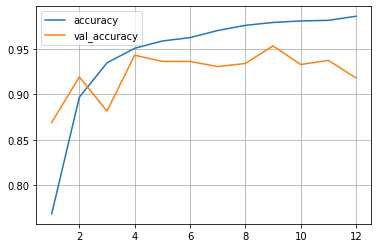

In [13]:
ax = plt.subplot(1,1,1)
line1 = ax.plot(range(1,epochs+1),history.history['accuracy'])
line2 = ax.plot(range(1,epochs+1),history.history['val_accuracy'])
plt.legend(["accuracy", "val_accuracy"])
plt.grid(visible=True, which='both', axis='both')
plt.show()

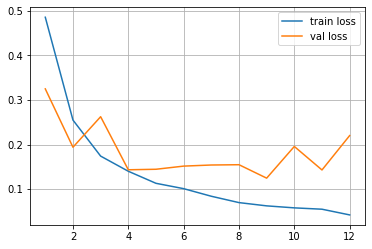

In [14]:
ax = plt.subplot(1,1,1)
line1 = ax.plot(range(1,epochs+1),history.history['loss'])
line2 = ax.plot(range(1,epochs+1),history.history['val_loss'])
# plt.ylim(0,0.4)
plt.legend(["train loss", "val loss"])
plt.grid(visible=True, which='both', axis='both')
plt.show()

In [15]:
loss, accuracy = model.evaluate(TestData)
print("Loss :", loss)
print("Accuracy :", accuracy)

1/1 [==============================] - 148s 148s/step - loss: 0.1418 - accuracy: 0.9534
Loss : 0.14181996881961823
Accuracy : 0.9533560872077942


In [16]:
#confusion matrix

predictions = model.predict(TestData)
predictions = np.argmin(predictions, axis=1)

test_y = next(TestData.as_numpy_iterator())[1]
test_y = np.argmin(test_y, axis = 1)

confusion_mat = tf.math.confusion_matrix(test_y,predictions)
TP = confusion_mat.numpy()[0,0];
FP = confusion_mat.numpy()[1,0];
FN = confusion_mat.numpy()[0,1];
TN = confusion_mat.numpy()[1,1];

precision=TP / (TP + FP)
recall=TP / (TP + FN)
print("Precision: " + str(precision));
print("Recall: " + str(recall));
print("confusion matrix: " + str(confusion_mat))

Precision: 0.9838709677419355
Recall: 0.9516380655226209
confusion matrix: tf.Tensor(
[[610  31]
 [ 10 228]], shape=(2, 2), dtype=int32)
